<a href="https://colab.research.google.com/github/HyoyeonLee/rccar/blob/main/learning_driving.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
 log in Google Account and Mount your Google Drive
    - Execute this code cell
    - Click the resulting URL
    - Log in, Copy the Key and Paste in the resulting box
    - Check if "drive" is properly mounted on the left explore space
"""
#from google.colab import drive
#drive.mount("/content/drive")

'\n log in Google Account and Mount your Google Drive\n    - Execute this code cell\n    - Click the resulting URL\n    - Log in, Copy the Key and Paste in the resulting box\n    - Check if "drive" is properly mounted on the left explore space\n'

# 1. Set up the environment suitable for Raspberry Pi
    - tensorflow, keras, h5py should not be the latest version.

In [ ]:
"""
Change Runtime Type from NONE to GPU and save
  - To synchronize versions of libraries with raspberry pi, un/re-install them
  - After executing, runtime> restart runtime
"""
!pip uninstall tensorflow -y
!pip install tensorflow==1.14
print("*******************************************")
!pip uninstall keras -y
!pip install keras==2.2.5
!pip install h5py==2.10.0

Found existing installation: tensorflow 2.6.0
Uninstalling tensorflow-2.6.0:
  Successfully uninstalled tensorflow-2.6.0
     |████████████████████████████████| 109.3 MB 46 kB/s 
     |████████████████████████████████| 488 kB 46.5 MB/s 
     |████████████████████████████████| 3.1 MB 34.3 MB/s 
     |████████████████████████████████| 50 kB 6.7 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.6.0
    Uninstalling tensorboard-2.6.0:
      Successfully uninstalled tensorboard-2.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kapre 0.3.5 requires tensorflow>=2.0.0, but you have tensorflow 1.14.0 which is incompatible.


# 2. Access my Google Drive where the zip file of the cam image data is.
    - when the drive appears on the left panel, unzip the file.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!rm -r -f /content/data

In [ ]:

!unzip -qq "/content/drive/MyDrive/rccar_data2/data.zip"

# 3. Create PANDAS data format (X:angle, Y:image) and import libraries

In [ ]:
import os
import random
import fnmatch
import datetime
import pickle

#-----------------------------------------------------------[1] Data Processing
"""
    While running on jupyter notebook, display results with a format...
  
  
  |----------------display.width----------------|
  ==============================================
  col1     |col2    |col3    |col4    |col5    |
  ----------------------------------------------
  0.0400   |12345...|        |        |        |
  0.0100   |        |        |        |        |
  0.0200   |<------>|        |        |        |
     |          |->display.max_colwidth
     |-> display.float_format (.4f)


"""
import numpy as np
import pandas as pd

np.set_printoptions(formatter={'float_kind':lambda x: "%.4f" %x})
pd.set_option('display.width',300)
pd.set_option('display.float_format','{:,.4f}'.format)
pd.set_option('display.max_colwidth',200)

#-----------------------------------------------------------[2] tensorflow
"""
Libraries needed to...
[DL]
  - extract features (Convolution), reduce data size (pooling), 
    repress overfitting(dropout), 2D img data to a 1D array(flatten), 
    set the DL layer structure (dense)
  - select optimizing algorithm
  - load existing models in the keras library
"""
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dropout,Flatten,Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
print("*******************************************")
#print(f'tf.__version__:{tf.__version__}')
print("tensorflow version : %s"%tf.__version__)
#print(f'.keras.__version__:{tensorflow.keras.__version__}')
print("tensorflow.keras version : %s"%tensorflow.keras.__version__)
print("*******************************************")
#-----------------------------------------------------------[3] sklearn
"""
[DATA structure]
  - Label, split, and feed data to a model
"""
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
#-----------------------------------------------------------[4] imaging
"""
[IMAGE]
  - when the object in the image ID-ed and boxed, image data along 
    with the box info can be dealt together using imgaug library
    This library performs rotation, shearing, resizing, and etc to augment
    the amount of image data, preventing overfitting.
  - %matplotlib inline : show image data as the program is running at jpt-nb
  - PIL : image process library change .bmp to jpeg something...
"""
import cv2
from imgaug import augmenters as img_aug
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline   
from PIL import Image  

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

*******************************************
tensorflow version : 1.14.0
tensorflow.keras version : 2.2.4-tf
*******************************************


# 4. Load the data and plug into the pandas data format.
    - take a look at the raw data; images and distributions w.r.t. angles

Image Data (X) file path : R00972A090.png
Steering Angle (Y) : 90[deg]
total number of data = 4003


'\n  IMPORTANT CHECK POINT !!!! \n  ----> three angles should be evenly distributed!\n'

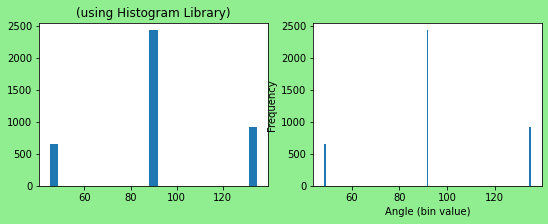

In [ ]:
#--------------------------------- Find Image Data from a folder and make a list
folder = '/content/data'   #name of data folder
all_fnames = os.listdir(folder)  #list of data file names in the folder
fnames_dataX = []
angles_dataY = []
for fname in all_fnames:
#         --> here it finds file name with an extension of ".png" 
  if fnmatch.fnmatch(fname, "*.png"):
    fnames_dataX.append(fname)
    angles_dataY.append(int(fname[7:10]))
#--------------------------------- Show a single data and its angle as a sample
idx_data = 0
#plt.imshow(Image.open(fnames_dataX[idx_data]))
#plt.imshow(Image.open(fnames_dataX[0]))
print("Image Data (X) file path : %s"%fnames_dataX[idx_data])
print("Steering Angle (Y) : %d[deg]"%angles_dataY[idx_data])
print("total number of data = %d"%len(angles_dataY))
#--------------------------------- Using Pandas, construct data structure
dataFrame = pd.DataFrame()
dataFrame['ImagePath'] = fnames_dataX
dataFrame['Angle'] = angles_dataY
#--------------------------------- Check the distrubution of data w.r.t angle
nbins = 25 #0[deg]~180[deg] dtheta=7.2[deg]
bin_frequency, bin_value = np.histogram(dataFrame['Angle'],nbins)
fig = plt.figure(figsize = (9,3))
fig.patch.set_facecolor("lightgreen")

sub1 = plt.subplot(1,2,1)
sub1.set_title("(using Histogram Library)")
sub1.hist(dataFrame["Angle"],bins=nbins)#(dataFrame[],bin_value)
sub2 = plt.subplot(1,2,2)
bin_value1=np.delete(bin_value,0)
sub2.bar(bin_value1,bin_frequency)
sub2.set_xlabel ("Angle (bin value)")
sub2.set_ylabel ( "Frequency")
"""
  IMPORTANT CHECK POINT !!!! 
  ----> three angles should be evenly distributed!
"""

# 5. Split the data into Training and Validating Data Set
    - check their distributions are somewhat similar to that of the origial data.

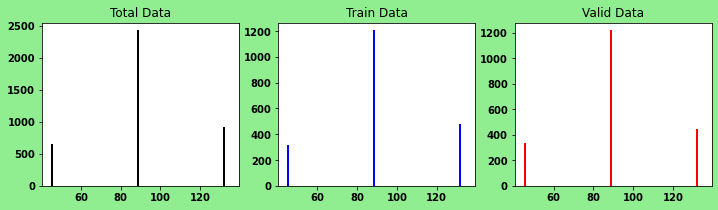

number of train data : valid data = 2001 : 2002
ratio angle 45 : 90 : 135
--------------------------------
data  | 0.71:2.62:1.00
train | 0.67:2.53:1.00
valid | 0.75:2.72:1.00


In [ ]:
#Edit " test_size = 0.2 " when lots of data available
trainX,validX,trainY,validY = train_test_split(fnames_dataX,angles_dataY,test_size = 0.5)
ntrain = len(trainY)
nvalid = len(validY)
fig = plt.figure(figsize = (12,3))
fig.patch.set_facecolor("lightgreen")
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
p1 = plt.subplot(1,3,1)
p1.hist(dataFrame['Angle'],bins=nbins,width=1,color='k')
p1.set_title("Total Data")
p1 = plt.subplot(1,3,2)
p1.hist(trainY,bins=nbins,width=1,color='b')
p1.set_title("Train Data")
p1 = plt.subplot(1,3,3)
p1.hist(validY,bins=nbins,width=1,color='r')
p1.set_title("Valid Data")
plt.show()
print("number of train data : valid data = %d : %d"%(ntrain,nvalid))
print("ratio angle 45 : 90 : 135")

print("--------------------------------")
k=sum([i ==135 for i in angles_dataY])*1.0
print("data  | %.2f:%.2f:%.2f"%(sum([i ==45 for i in angles_dataY])/k,sum([i ==90 for i in angles_dataY])/k,1))
k1=sum([i ==135 for i in trainY])*1.0
print("train | %.2f:%.2f:%.2f"%(sum([i ==45 for i in trainY])/k1,sum([i ==90 for i in trainY])/k1,1))
k2=sum([i ==135 for i in validY])*1.0
print("valid | %.2f:%.2f:%.2f"%(sum([i ==45 for i in validY])/k2,sum([i ==90 for i in validY])/k2,1))


# 6. Normalize Color Values
    - from (0~255) to (0~1.0) by dividing each channel by 255.0
    - this preprocessing helps the Machine Learning run faster.

Text(0.5, 1.0, 'normalized values in depth')

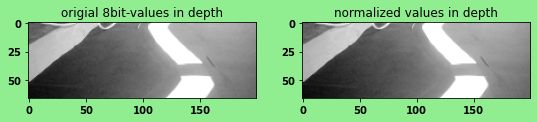

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
fig = plt.figure(figsize = (9,3))
fig.patch.set_facecolor("lightgreen")
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
p1 = plt.subplot(1,2,1)
p2 = plt.subplot(1,2,2)
tempidx = 0
path1 = folder+"/"+fnames_dataX[tempidx]
src = cv2.imread(path1)
#src = cv2.imread("/content/data/R00000A090.png")
#cv2_imshow(src)
p1.imshow(src)
#if src is not None:
#    src1 = image / 255

p1.set_title("origial 8bit-values in depth")
src1=src/255.0
p2.imshow(src1)
p2.set_title("normalized values in depth")

# 7. Set up the Deep Learning Model 
    - relu discards values below zero, preventing a bias towards zero.
    - Here, instead of relu, elu is chosen, allowing a bit of negative results.
    - Dropout deletes some overlapping results and save the model from overfitting.

In [ ]:
def deepLearning_model():
    model = Sequential(name='Nvidia_Model')
    model.add(Conv2D(24,(5,5),strides=(2,2),input_shape = (66,200,3), activation='elu'))
    model.add(Conv2D(36,(5,5),strides=(2,2),activation='elu'))
    model.add(Conv2D(48,(5,5),strides=(2,2),activation='elu'))
    model.add(Conv2D(64,(3,3),activation='elu'))
    model.add(Dropout(0.2))
    model.add(Conv2D(64,(3,3),activation='elu'))

    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(100,activation='elu'))
    model.add(Dense(50,activation='elu'))
    model.add(Dense(10,activation='elu'))
    model.add(Dense(1))
    optimizer= Adam(lr=1e-3)
    model.compile(loss='mse',optimizer=optimizer)
    return model

model = deepLearning_model()
print(model.summary())


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "Nvidia_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
dropout (Dropout)            (None, 3, 20, 64)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 18, 64)         36928     
__

# 8. Using a Generator, shape the data to be fed into Deep Learning Model
    - designating a batch size reduces learning time tremendously
    

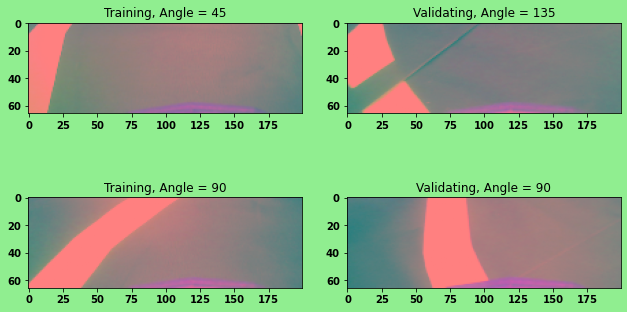

In [ ]:
def auto_label_generator(image_paths,angles,batch_size):
    while True:
      batch_images = []
      batch_angles = []
      for i in range(0,batch_size):
        idx = random.randint(0,len(image_paths)-1)
        path = folder+"/"+image_paths[idx]
        image = cv2.imread(path)/255.0
        angle = angles_dataY[idx]
        batch_images.append(image)
        batch_angles.append(angle)
      yield(np.asarray(batch_images),np.asarray(batch_angles))


ncols=2
nrows=2
trainBX,trainBY = next(auto_label_generator(trainX,trainY,nrows))
validBX,validBY = next(auto_label_generator(validX,validY,nrows))
fig,p= plt.subplots(nrows,ncols,figsize = (9,5))
fig.patch.set_facecolor("lightgreen")
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
fig.tight_layout()
for i in (0,1):
    p[i][0].imshow(trainBX[i])
    p[i][0].set_title("Training, Angle = %s"%trainBY[i])
    p[i][1].imshow(validBX[i])
    p[i][1].set_title("Validating, Angle = %s"%validBY[i])

# 9. Learn Parameter of the DL model using Training DataSet
    - checkpoint_callback will keep track of learning progress
    - the loss should decrease with each epoch.
    - create history file with binary form

In [ ]:
path_resulting_model = "/content/drive/MyDrive/rccar_camdata/"
path_check_out = path_resulting_model+ "rccar_DL_model_check.h5"
path_final_out = path_resulting_model+ "rccar_DL_model_final.h5"
path_history_out = path_resulting_model+ "rccar_DL_model_history.pickle"
#checkpoint_callback = tensorflow.callbacks.ModelCheckpoint(filepath = os.path.join())
checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(filepath=path_check_out,verbos=1,save_best_only=True)
history = model.fit_generator(
                              auto_label_generator(trainX,trainY,batch_size=3),
                              steps_per_epoch=300,epochs=10,
                              validation_data=auto_label_generator(validX,validY,batch_size=3),
                              validation_steps=200,
                              verbose=1,shuffle=1,callbacks=[checkpoint_callback])
model.save(path_final_out)
with open(path_history_out,'wb') as f:
  pickle.dump(history.history,f,pickle.HIGHEST_PROTOCOL)
 

Epoch 1/10
300/300 [==============================] - 13s 42ms/step - loss: 830.4697 - val_loss: 865.7306
Epoch 2/10
300/300 [==============================] - 12s 40ms/step - loss: 855.6702 - val_loss: 924.9908
Epoch 3/10
300/300 [==============================] - 12s 41ms/step - loss: 844.8313 - val_loss: 849.4290
Epoch 4/10
300/300 [==============================] - 13s 42ms/step - loss: 792.0591 - val_loss: 705.3393
Epoch 5/10
300/300 [==============================] - 12s 41ms/step - loss: 830.9571 - val_loss: 882.4298
Epoch 6/10
300/300 [==============================] - 12s 41ms/step - loss: 855.0424 - val_loss: 844.4051
Epoch 7/10
300/300 [==============================] - 13s 42ms/step - loss: 850.7204 - val_loss: 801.6282
Epoch 8/10
300/300 [==============================] - 12s 41ms/step - loss: 817.5056 - val_loss: 786.6070
Epoch 9/10
300/300 [==============================] - 12s 42ms/step - loss: 848.6871 - val_loss: 767.1151
Epoch 10/10
300/300 [=========================

# 10. The Learning Curve 
    - as learning occurs at each epoch, the training loss gets reduced.
    - basically the same trend is expected for validation loss, however, a number of features here are affecting the performance such as lack of data.
    

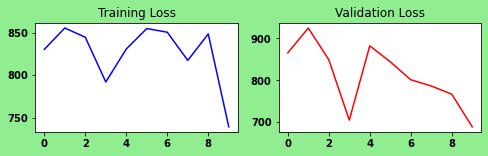

In [ ]:
#history.history #???

with open(path_history_out,'rb') as f:
  history = pickle.load(f)

history #???

fig = plt.figure(figsize = (8,2))
fig.patch.set_facecolor("lightgreen")
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
p1=plt.subplot(1,2,1)
p1.set_title("Training Loss")
p1.plot(history['loss'],'b')
p2=plt.subplot(1,2,2)
p2.set_title("Validation Loss")
p2.plot(history['val_loss'],'r')


# 11. Try predict an Angle
    - with a randomly chosen image and angle info from a validation dataset, try predict an angle based on the DL model.
    - The difference between true and predicted angle should be small.

      MSE = 592.41
R_Squared = -0.32



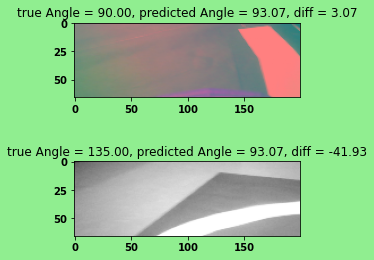

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
def prediction_summary(trueY,predictedY):
  mse = mean_squared_error(trueY,predictedY)
  r2_squared = r2_score(trueY,predictedY)
  print("      MSE = %.2f"%mse)
  print("R_Squared = %.2f"%r2_squared)
  print()

def predict_and_summarize(X,Y):
  model = load_model(path_check_out)
  predictedY = model.predict(X)
  prediction_summary(Y,predictedY)
  return predictedY

ntests =10
testX,testY = next(auto_label_generator(validX,validY,3))
predictedY = predict_and_summarize(testX,testY)

ncols=1
nrows=2
fig,p= plt.subplots(nrows,ncols,figsize = (4,4))
fig.patch.set_facecolor("lightgreen")
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
fig.tight_layout()
for i in (0,1):
    p[i].imshow(testX[i])
    p[i].set_title("true Angle = %.2f, predicted Angle = %.2f, diff = %.2f" \
                   %(testY[i],predictedY[i],predictedY[i]-testY[i]))
    

In [ ]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pandoc is already the newest version (1.19.2.4~dfsg-1build4).
pandoc set to manually installed.
The following additional packages will be installed:
  fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono fonts-texgyre
  javascript-common libcupsfilters1 libcupsimage2 libgs9 libgs9-common
  libijs-0.35 libjbig2dec0 libjs-jquery libkpathsea6 libpotrace0 libptexenc1
  libruby2.5 libsynctex1 libtexlua52 libtexluajit2 libzzip-0-13 lmodern
  poppler-data preview-latex-style rake ruby ruby-did-you-mean ruby-minitest
  ruby-net-telnet ruby-power-assert ruby-test-unit ruby2.5
  rubygems-integration t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-fonts-recommended texlive-latex-base
  texlive-latex-recommended texlive-pictures texlive-plain-generic tipa
Suggested packages:
  fonts-noto apache2 | lighttpd | httpd poppler-utils ghostscript
  fonts-japanese-mincho | fonts-ipa

In [ ]:
!jupyter nbconvert --to PDF '/content/drive/MyDrive/Colab Notebooks/learning_driving.ipynb'

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/learning_driving.ipynb to PDF
[NbConvertApp] Support files will be in learning_driving_files/
[NbConvertApp] Making directory ./learning_driving_files
[NbConvertApp] Making directory ./learning_driving_files
[NbConvertApp] Making directory ./learning_driving_files
[NbConvertApp] Making directory ./learning_driving_files
[NbConvertApp] Making directory ./learning_driving_files
[NbConvertApp] Making directory ./learning_driving_files
[NbConvertApp] Writing 106755 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: [u'xelatex', u'./notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: [u'bibtex', u'./notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 266966 bytes to /content/drive/MyDrive/Colab Notebooks/learning_driving.pdf
